# LDA-Based Document Classification

This notebook implements a streamlined LDA-based approach to classify legal documents into three categories:
- final-approval
- preliminary-approval
- voluntary-dismissal

In [1]:
# Cell 0 - Package Installation
%pip install numpy pandas matplotlib seaborn nltk gensim PyMuPDF --quiet


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Cell 1 - Configuration
TRAINING_DIR = "training"
MODEL_DIR = "lda_model"

# Basic English stopwords - common words that don't add meaning
STOPWORDS = set([
    "the", "and", "a", "to", "of", "in", "that", "is", "for", "on", "it", "with",
    "as", "be", "this", "by", "are", "at", "or", "not", "an", "from", "but",
    "which", "they", "their", "have", "has", "had", "will", "would"
])

# Legal-specific stopwords that appear in all categories
LEGAL_STOPWORDS = set([
    "plaintiff", "plaintiffs", "defendant", "defendants", "v", "vs", "versus",
    "et", "al", "page"
])

STOPWORDS.update(LEGAL_STOPWORDS)

# Model parameters
NUM_TOPICS = 15  # Number of topics for the LDA model
MIN_TOKEN_LENGTH = 3  # Minimum length for tokens to consider
NUM_PASSES = 25  # Number of passes during training
RANDOM_SEED = 42  # For reproducibility

In [3]:
# Cell 2 - Imports
import os
import json
import numpy as np
import pandas as pd
import fitz  # PyMuPDF
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import gensim
from gensim import corpora
from gensim.models import LdaModel

nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)

True

In [4]:
# Cell 3 - Helper Functions
def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file."""
    text = ""
    try:
        with fitz.open(pdf_path) as doc:
            for page in doc:
                text += page.get_text()
    except Exception as e:
        print(f"Error extracting text from {pdf_path}: {e}")
    return text

def extract_document_header(text, max_chars=3000):
    """Extract the beginning portion of the document."""
    # The document header typically contains most relevant categorization info
    return text[:max_chars]

def preprocess_text(text):
    # Extract header first for better focus on key content
    header_text = extract_document_header(text)
    
    # Convert to lowercase and tokenize
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(header_text.lower())
    
    # Remove stopwords and short tokens
    tokens = [token for token in tokens 
              if token not in STOPWORDS and len(token) >= MIN_TOKEN_LENGTH]
    
    # Lemmatize tokens to group similar words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    text_lower = header_text.lower()
    
    # Add category-specific tokens for preliminary approval documents
    if any(term in text_lower for term in ["preliminary approval", "preliminarily approve", 
                                           "conditional certification", "conditionally certify",
                                           "preliminary settlement", "approve preliminary",
                                           "motion for preliminary", "preliminarily approved",
                                           "preliminary certification", "preliminary class"]):
        tokens.extend(["preliminary_approval"] * 8)  # Multiple instances to increase weight
    
    # Add tokens for settlement-related terms
    if any(term in text_lower for term in ["proposed settlement", "settlement class", 
                                          "notice plan", "notice program", "settlement notice",
                                          "notice to class", "notice to the class", "class notice",
                                          "settlement agreement", "settlement administrator"]):
        tokens.extend(["proposed_settlement"] * 6)
        
    # Add tokens for class certification
    if any(term in text_lower for term in ["class certification", "certify class", 
                                          "class representative", "class definition",
                                          "certification of class", "conditionally certify",
                                          "appoint class", "class counsel"]):
        tokens.extend(["class_certification"] * 6)
        
    # Add tokens for preliminary motions
    if any(term in text_lower for term in ["motion for preliminary", "granting preliminary", 
                                          "preliminary certification", "approval of notice", 
                                          "preliminary approving", "conditionally approved"]):
        tokens.extend(["preliminary_motion"] * 7)
    
    # Add tokens for final approval
    if any(term in text_lower for term in ["final approval", "finally approve", "finally approved", 
                                          "final judgment", "final settlement", "final order"]):
        tokens.extend(["final_approval"] * 4)
        
    # Add tokens for attorney fees (common in final approval)
    if any(term in text_lower for term in ["attorney fee", "attorneys fee", "fee award", "award fee", 
                                          "fee application", "service award", "incentive award", 
                                          "award attorney", "reasonable fee", "class counsel fee"]):
        tokens.extend(["attorney_fees"] * 4)
        
    # Add tokens for settlement fairness
    if any(term in text_lower for term in ["fairness hearing", "settlement fairness", "fair reasonable", 
                                          "finally settled", "fair reasonable adequate"]):
        tokens.extend(["settlement_fairness"] * 3)
    
    # Add tokens for voluntary dismissal
    if any(term in text_lower for term in ["voluntary dismiss", "stipulation of dismissal", 
                                           "jointly stipulate", "voluntarily dismiss",
                                           "dismiss the case", "dismiss this action"]):
        tokens.extend(["voluntary_dismissal"] * 3)
        
    # Add tokens for dismissal stipulations
    if any(term in text_lower for term in ["without prejudice", "with prejudice", 
                                          "stipulate dismiss", "dismiss action", 
                                          "stipulated dismissal", "dismissal stipulation"]):
        tokens.extend(["stipulated_dismissal"] * 3)
    
    # Create important bigrams to capture multi-word concepts
    important_bigrams = []
    for i in range(len(tokens) - 1):
        bigram = f"{tokens[i]}_{tokens[i+1]}"
        if ((tokens[i] in ["preliminary", "final", "voluntary", "proposed", "class", "notice", "fairness", "settlement", "motion", "approval"] or 
             tokens[i+1] in ["approval", "dismiss", "settlement", "class", "certification", "hearing", "granted", "denied", "fee", "award"])):
            important_bigrams.append(bigram)
    
    tokens.extend(important_bigrams)
    return tokens

def detect_category_keywords(doc_text):
    """Detect category-specific keywords in document text."""
    text_lower = doc_text.lower()
    
    # Key phrases that indicate final approval
    final_approval_patterns = [
        "final approval", "finally approve", "finally approved",
        "hereby finally approves", "grants final approval",
        "final order and judgment", "final judgment",
        "award of attorney", "attorneys' fees", "fee award",
        "service award", "incentive award",
        "settlement is fair", "fair, reasonable, and adequate"
    ]
    
    # Key phrases that indicate preliminary approval
    preliminary_approval_patterns = [
        "preliminary approval", "preliminarily approve", "preliminarily approves",
        "preliminarily approved", "grants preliminary approval",
        "hereby preliminarily approves", "conditional certification",
        "conditionally certifies", "notice to the class",
        "notice plan", "notice administrator", "notice program",
        "proposed settlement", "settlement class", "class notice"
    ]
    
    # Key phrases that indicate voluntary dismissal
    voluntary_dismissal_patterns = [
        "voluntary dismiss", "voluntarily dismissed", 
        "stipulated dismissal", "stipulation of dismissal",
        "dismiss this action", "dismiss the action", "dismiss the case",
        "dismissal with prejudice", "dismissal without prejudice",
        "jointly stipulate"
    ]
    
    # Count pattern matches for each category
    final_count = sum(1 for pattern in final_approval_patterns if pattern in text_lower)
    prelim_count = sum(1 for pattern in preliminary_approval_patterns if pattern in text_lower)
    vol_dismiss_count = sum(1 for pattern in voluntary_dismissal_patterns if pattern in text_lower)
    
    # Calculate normalized scores (0.0-1.0) for each category
    final_direct_score = min(1.0, final_count / max(len(final_approval_patterns) * 0.3, 1))
    prelim_direct_score = min(1.0, prelim_count / max(len(preliminary_approval_patterns) * 0.3, 1))
    vol_direct_score = min(1.0, vol_dismiss_count / max(len(voluntary_dismissal_patterns) * 0.3, 1))
    
    return {
        "final-approval": final_direct_score,
        "preliminary-approval": prelim_direct_score,
        "voluntary-dismissal": vol_direct_score
    }

def optimized_lda_classifier(doc_text, lda_model, dictionary, topic_to_category):
    """Hybrid classifier combining LDA topic modeling with direct keyword detection."""
    # Preprocess text to get tokens
    tokens = preprocess_text(doc_text)
    doc_text_lower = doc_text.lower()
    
    # Get direct keyword scores
    keyword_scores = detect_category_keywords(doc_text)
    
    # Additional token boosting for final approval documents
    if any(term in doc_text_lower for term in [
        "attorney fee", "attorneys fee", "fee award", "attorney fees", "attorneys' fees",
        "service award", "incentive award", "final judgment", "final approval",
        "finally approve", "final order", "fair reasonable adequate"
    ]):
        tokens.extend(["final_approval"] * 3 + ["attorney_fees"] * 3 + ["final_judgment"] * 2)
    
    # Additional token boosting for preliminary approval documents
    if any(term in doc_text_lower for term in [
        "preliminary approval", "preliminarily approve", "proposed settlement", 
        "settlement class", "notice plan", "notice program", "class notice",
        "motion for preliminary", "preliminary settlement", "notice to class",
        "certification of class", "conditionally certify", "conditionally approved",
        "preliminary approving", "preliminary certification", "notice administrator",
        "notice program", "settlement agreement", "settlement approval",
        "approval of settlement", "appoint class", "certify the settlement class"
    ]):
        tokens.extend(["preliminary_approval"] * 8 + ["proposed_settlement"] * 5 + ["class_notice"] * 5)
    
    # Additional checks for common word combinations
    if "preliminary" in doc_text_lower and "approve" in doc_text_lower:
        tokens.extend(["preliminary_approval"] * 6)
    if "proposed" in doc_text_lower and "settlement" in doc_text_lower:
        tokens.extend(["proposed_settlement"] * 5)
    if "notice" in doc_text_lower and ("class" in doc_text_lower or "settlement" in doc_text_lower):
        tokens.extend(["class_notice"] * 5)
    
    # Additional token boosting for voluntary dismissal documents
    if any(term in doc_text_lower for term in ["voluntary dismiss", "stipulation", "with prejudice", 
                                              "without prejudice", "dismiss action", "dismiss the case",
                                              "dismiss this action", "dismissal stipulation"]):
        tokens.extend(["voluntary_dismissal"] * 3 + ["stipulated_dismissal"] * 2)
    
    # Convert to bag-of-words for LDA
    bow = dictionary.doc2bow(tokens)
    topic_dist = lda_model.get_document_topics(bow)
    
    # Initialize with baseline scores to balance categories
    category_scores = {
        "final-approval": 0.18,       # Small boost for final approval
        "preliminary-approval": 0.3,  # Larger boost for preliminary (harder to detect)
        "voluntary-dismissal": 0.08   # Small boost for voluntary dismissal
    }
    
    total_weight = 0.56  # Sum of initial weights
    
    # Process topic distribution from LDA model
    for topic_idx, prob in topic_dist:
        if str(topic_idx) in topic_to_category:
            category = topic_to_category[str(topic_idx)]
            weight = prob
            
            # Apply probability-based boosting
            if prob > 0.2:  # Strong topic signal
                weight *= 1.2
            if category == "final-approval" and prob > 0.15:
                weight *= 1.2  # Extra boost for final approval
            if category == "preliminary-approval" and prob > 0.06:
                weight *= 1.5  # Significant boost for preliminary approval
            if category == "voluntary-dismissal" and prob > 0.12:
                weight *= 1.35  # Good boost for voluntary dismissal
            
            category_scores[category] += weight
            total_weight += weight
    
    # Set weight ratio between LDA and keyword detection
    lda_weight = 0.7     # 70% LDA model
    keyword_weight = 0.3  # 30% direct keyword detection
    
    # Combine LDA scores with keyword detection scores
    combined_scores = {}
    for category in category_scores:
        lda_score = category_scores[category] / total_weight if total_weight > 0 else 0
        combined_scores[category] = (lda_score * lda_weight) + (keyword_scores[category] * keyword_weight)
    
    # Extra boost for strong preliminary approval signals
    if keyword_scores["preliminary-approval"] > 0.3:
        combined_scores["preliminary-approval"] *= 1.2
    
    # Find the category with highest combined score
    best_category = max(combined_scores.items(), key=lambda x: x[1])[0]
    confidence = combined_scores[best_category]
    
    return best_category, confidence

In [5]:
# Cell 4 - Load and Process PDF Files
all_pdf_paths = []
doc_ids = []
true_labels = []

# Find all PDFs in our training subdirectories
for category in os.listdir(TRAINING_DIR):
    category_dir = os.path.join(TRAINING_DIR, category)
    if os.path.isdir(category_dir):
        for filename in os.listdir(category_dir):
            if filename.endswith('.pdf'):
                pdf_path = os.path.join(category_dir, filename)
                all_pdf_paths.append(pdf_path)
                doc_ids.append(os.path.splitext(filename)[0])
                true_labels.append(category)

documents = []
doc_texts = {}

# Extract text from each PDF and preprocess
for pdf_path, doc_id in zip(all_pdf_paths, doc_ids):
    doc_text = extract_text_from_pdf(pdf_path)
    doc_texts[doc_id] = doc_text
    
    tokens = preprocess_text(doc_text)
    documents.append(tokens)

In [6]:
# Cell 5 - Build and Train LDA Model

# Create dictionary with filtering to remove rare and very common terms
dictionary = corpora.Dictionary(documents)
dictionary.filter_extremes(no_below=2, no_above=0.8)  # Keep terms in 2+ docs but not in >80% docs

# Create document-term matrix
corpus = [dictionary.doc2bow(doc) for doc in documents]

# Train LDA model with optimized parameters
lda = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    passes=NUM_PASSES,
    alpha='symmetric',  # Equal prior weight to all topics
    eta='auto',         # Let model learn term weights
    random_state=RANDOM_SEED,
    iterations=500      # More iterations for better convergence
)

# Save model and dictionary for future use
os.makedirs(MODEL_DIR, exist_ok=True)
dictionary_path = os.path.join(MODEL_DIR, 'dictionary.pkl')
model_path = os.path.join(MODEL_DIR, 'lda_model')

dictionary.save(dictionary_path)
lda.save(model_path)

# Save model parameters
params = {
    'num_topics': NUM_TOPICS,
    'passes': NUM_PASSES,
    'min_token_length': MIN_TOKEN_LENGTH
}

params_path = os.path.join(MODEL_DIR, 'model_params.json')
with open(params_path, 'w') as f:
    json.dump(params, f)

In [7]:
# Cell 6 - Topic to Category Mapping

# Calculate average topic distribution for each category
category_topic_dist = defaultdict(lambda: np.zeros(NUM_TOPICS))
category_doc_counts = defaultdict(int)

for doc_id, true_label, doc in zip(doc_ids, true_labels, corpus):
    topic_dist = lda.get_document_topics(doc, minimum_probability=0)
    topic_probs = np.zeros(NUM_TOPICS)
    
    for topic_id, prob in topic_dist:
        topic_probs[topic_id] = prob
        
    category_topic_dist[true_label] += topic_probs
    category_doc_counts[true_label] += 1

# Calculate average topic distribution for each category
for category in category_topic_dist:
    if category_doc_counts[category] > 0:
        category_topic_dist[category] /= category_doc_counts[category]

# Map each topic to its most likely category
topic_to_category = {}

for topic_id in range(NUM_TOPICS):
    best_category = None
    best_avg_prob = -1
    
    for category, avg_dist in category_topic_dist.items():
        avg_prob = avg_dist[topic_id]
        if avg_prob > best_avg_prob:
            best_avg_prob = avg_prob
            best_category = category
    
    topic_to_category[str(topic_id)] = best_category

# Ensure preliminary-approval has sufficient representation
# This helps prevent this category from being underrepresented
prelim_topics_count = sum(1 for cat in topic_to_category.values() if cat == "preliminary-approval")
min_prelim_topics = 4  # Minimum number of topics we want for preliminary approval

if prelim_topics_count < min_prelim_topics:
    potential_reassignments = []
    
    for topic_id in range(NUM_TOPICS):
        if topic_to_category[str(topic_id)] != "preliminary-approval":
            prelim_prob = category_topic_dist["preliminary-approval"][topic_id]
            current_cat = topic_to_category[str(topic_id)]
            current_prob = category_topic_dist[current_cat][topic_id]
            
            # If preliminary-approval probability is reasonably close to current category
            if prelim_prob > 0.5 * current_prob:
                potential_reassignments.append((topic_id, current_prob - prelim_prob))
    
    # Sort by smallest probability difference
    potential_reassignments.sort(key=lambda x: x[1])
    
    # Reassign topics until we have enough preliminary-approval topics
    needed = min_prelim_topics - prelim_topics_count
    for topic_id, _ in potential_reassignments[:needed]:
        topic_to_category[str(topic_id)] = "preliminary-approval"

# Save topic-to-category mapping
topic_map_path = os.path.join(MODEL_DIR, 'topic_to_category.json')
with open(topic_map_path, 'w') as f:
    json.dump(topic_to_category, f)

In [8]:
# Cell 7 - Document Classification and Evaluation

predictions = []
confidences = []
category_distributions = []
doc_top_words = []

categories = ["final-approval", "preliminary-approval", "voluntary-dismissal"]

# Helper function to get top words for each topic
def get_topic_top_words(lda_model, dictionary, n=10):
    topic_words = {}
    for topic_id in range(lda_model.num_topics):
        words = lda_model.show_topic(topic_id, n)
        topic_words[topic_id] = [word for word, _ in words]
    return topic_words

topic_top_words = get_topic_top_words(lda, dictionary)

# Classify each document using our optimized hybrid approach
for doc_id, doc in zip(doc_ids, corpus):
    doc_text = doc_texts[doc_id]
    
    # Get prediction using our optimized classifier
    pred_category, confidence = optimized_lda_classifier(doc_text, lda, dictionary, topic_to_category)
    
    predictions.append(pred_category)
    confidences.append(confidence)
    
    # For detailed analysis, recalculate scores for each document
    tokens = preprocess_text(doc_text)
    
    # Get keyword-based scores
    keyword_scores = detect_category_keywords(doc_text)
    
    # Get LDA topic distribution
    bow = dictionary.doc2bow(tokens)
    topic_dist = lda.get_document_topics(bow)
    
    # Calculate raw category scores from topics with baseline values
    category_scores = {
        "final-approval": 0.18,
        "preliminary-approval": 0.3,
        "voluntary-dismissal": 0.08
    }
    
    total_weight = 0.56  # Initial sum of baseline weights
    
    # Process topic distribution
    for topic_idx, prob in topic_dist:
        if str(topic_idx) in topic_to_category:
            category = topic_to_category[str(topic_idx)]
            weight = prob
            
            # Apply probability-based boosting
            if prob > 0.2:
                weight *= 1.2
            if category == "final-approval" and prob > 0.15:
                weight *= 1.2
            if category == "preliminary-approval" and prob > 0.06:
                weight *= 1.5
            if category == "voluntary-dismissal" and prob > 0.12:
                weight *= 1.35
                
            category_scores[category] += weight
            total_weight += weight
    
    # Calculate combined scores (70% LDA + 30% keywords)
    combined_scores = {}
    for category in categories:
        lda_score = category_scores[category] / total_weight if total_weight > 0 else 0
        combined_scores[category] = (lda_score * 0.7) + (keyword_scores[category] * 0.3)
    
    # Special boost for preliminary approval with strong keyword evidence
    if keyword_scores["preliminary-approval"] > 0.3:
        combined_scores["preliminary-approval"] *= 1.2
    
    # Store category probability distribution
    category_distributions.append([combined_scores[cat] for cat in categories])
    
    # Get top words for this document's topics
    top_topics = sorted(topic_dist, key=lambda x: x[1], reverse=True)[:3]
    
    doc_words = []
    for topic_id, _ in top_topics:
        doc_words.extend(topic_top_words[topic_id])
    
    # Store unique top words for this document
    unique_words = list(dict.fromkeys(doc_words))[:10]
    doc_top_words.append(", ".join(unique_words))

# Create results dataframe
results_df = pd.DataFrame({
    'doc_id': doc_ids,
    'true_category': true_labels,
    'predicted_category': predictions,
    'confidence': confidences,
    'top_words': doc_top_words
})

# Add category probability columns
for i, category in enumerate(categories):
    clean_name = category.replace('-', '_')
    column_name = f'category_prob_{clean_name}'
    results_df[column_name] = [dist[i] for dist in category_distributions]

# Calculate overall accuracy
accuracy = (results_df['true_category'] == results_df['predicted_category']).mean() * 100

# Calculate per-category accuracy
category_counts = {}
category_correct = {}

for category in set(true_labels):
    category_mask = results_df['true_category'] == category
    category_counts[category] = sum(category_mask)
    category_correct[category] = sum(
        results_df.loc[category_mask, 'true_category'] == results_df.loc[category_mask, 'predicted_category']
    )

# Save results to CSV
csv_path = 'document_classification_results.csv'
results_df.to_csv(csv_path, index=False)

# Preview results table
preview_columns = [
    'doc_id', 
    'true_category', 
    'predicted_category',
    'confidence',
    'category_prob_final_approval', 
    'category_prob_preliminary_approval', 
    'category_prob_voluntary_dismissal',
    'top_words'
]

display(results_df[preview_columns].head(5))

,doc_id,true_category,predicted_category,confidence,category_prob_final_approval,category_prob_preliminary_approval,category_prob_voluntary_dismissal,top_words
0,"Louis et al v. SAFERENT SOLUTIONS, LLC et al -...",final-approval,final-approval,0.775619,0.775346,0.378917,0.127938,"settlement, class, preliminary_approval, propo..."
1,Sellers et al v. Trustees of Boston College et...,final-approval,final-approval,0.838062,0.866639,0.286342,0.028076,"settlement, class, final_approval, class_certi..."
2,Getz v. Nelson et al - Entry 32,final-approval,final-approval,0.775585,0.780974,0.486296,0.028066,"settlement, final_approval, proposed_settlemen..."
3,"Perkins v. Ryder Integrated Logistics, Inc. - ...",final-approval,final-approval,0.848813,0.831976,0.408022,0.028006,"settlement, final_approval, proposed_settlemen..."
4,Seidner et al v. Kimberly-Clark Corporation et...,final-approval,final-approval,0.839118,0.852414,0.366285,0.028063,"settlement, class, final_approval, class_certi..."


In [9]:
# Cell 8 - Performance Metrics

print(f"Overall accuracy: {accuracy:.1f}%")
for category in sorted(category_counts.keys()):
    correct = category_correct[category]
    total = category_counts[category]
    cat_acc = (correct / total) * 100
    print(f"{category}: {cat_acc:.1f}% ({correct}/{total})")

Overall accuracy: 83.3%
final-approval: 80.0% (24/30)
preliminary-approval: 76.7% (23/30)
voluntary-dismissal: 93.3% (28/30)


/var/folders/s8/w_3n_b5j4fx19hv5x2tmjz_c0000gp/T/ipykernel_16614/2106591777.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=results_df, x='predicted_category', palette='Set2')


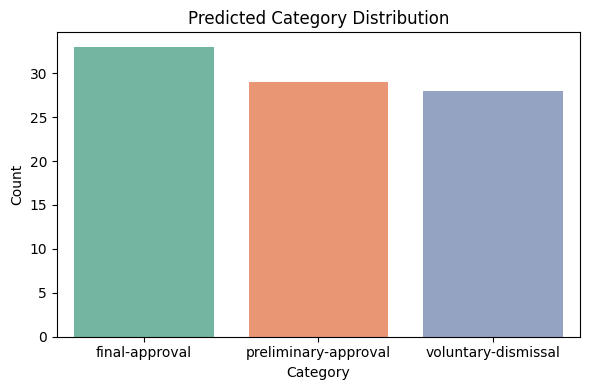

In [10]:
# Visualize predicted category distribution

plt.figure(figsize=(6, 4))
sns.countplot(data=results_df, x='predicted_category', palette='Set2')
plt.title('Predicted Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()